# EMRI Example with FEW

To run this example you will have to have few installed.
This can done by installing this package with the dev option.

`pip install . [dev]`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline

import jax.numpy as jnp

from few.amplitude.romannet import RomanAmplitude
from few.trajectory.ode.flux import SchwarzEccFlux
from few.trajectory.inspiral import EMRIInspiral
from few.utils.ylm import GetYlms
from few.waveform import FastSchwarzschildEccentricFlux
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.utils.constants import *

import WDM

import TimeFrequencyWaveforms as TFW

import time

In [2]:
traj = EMRIInspiral(func=SchwarzEccFlux)
amp = RomanAmplitude()
ylm_gen = GetYlms()

inspiral_kwargs = {"DENSE_STEPPING": 0, "max_init_len": int(1e3)}
amplitude_kwargs = {}
Ylm_kwargs = {}
sum_kwargs = {"pad_output": False}

## Source Parameters

In [3]:
M     = 1.0e6     # Central black hole mass [Msun]
mu    = 5.0e1     # Compact object mass [Msun]
p0    = 10.0      # Initial semi-latus rectum [M]
e0    = 0.4       # Initial eccentricity    
theta = np.pi/4.  # Polar viewing angle [rad]
phi   = np.pi/3.  # Azimuthal viewing angle [rad]
dist  = 1.0       # Luminosity distance [Gpc] 
T     = 1.0       # Maximum duration [yr]

## Trajectory

Compute the trajectory of the compact object using `few`.

In [4]:
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=T)

Plot the trajectory.

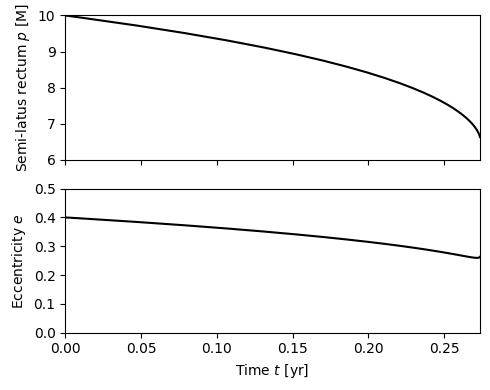

In [5]:
fig, axes = plt.subplots(figsize=(5,4), nrows=2, sharex=True)
axes[0].plot(t/3.154e7, p, 'k-')
axes[0].set_ylabel(r"Semi-latus rectum $p$ [M]")
axes[0].set_ylim(6, 10)
axes[1].plot(t/3.154e7, e, 'k-')
axes[1].set_ylabel(r"Eccentricity $e$")
axes[1].set_ylim(0, 0.5)
axes[1].set_xlabel(r"Time $t$ [yr]")
axes[1].set_xlim(0, t[-1]/3.154e7)
plt.tight_layout()
plt.show()

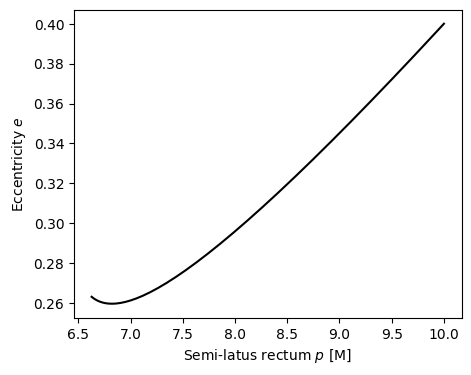

In [6]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(p, e, 'k-')
ax.set_xlabel(r"Semi-latus rectum $p$ [M]")
ax.set_ylabel(r"Eccentricity $e$")
plt.show()

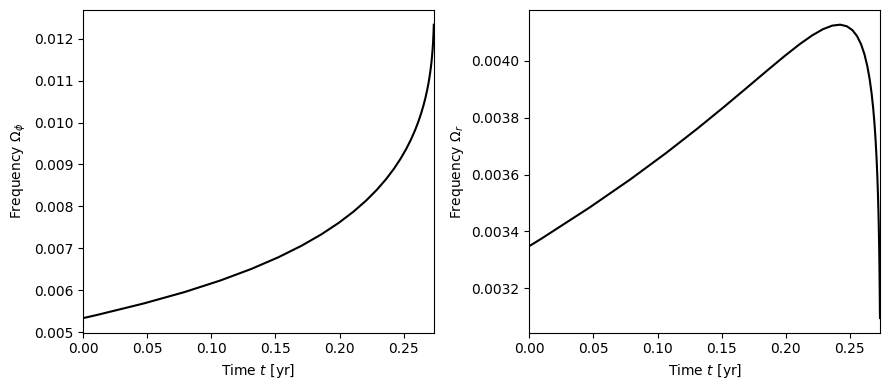

In [7]:
fig, axes = plt.subplots(figsize=(9,4), ncols=2)
for i, phase in enumerate([Phi_phi, Phi_r]):
    axes[i].plot(t/3.154e7, np.gradient(phase, t), 'k-')
    axes[i].set_xlabel(r"Time $t$ [yr]")
    label = [r"$\Omega_\phi$", r"$\Omega_r$"][i]
    axes[i].set_ylabel(r"Frequency "+label)
    axes[i].set_xlim(0, t[-1]/3.154e7)
plt.tight_layout()
plt.show()

## Full EMRI Waveform

Use `few` to compute the full waveform (inc. all harmonics).

In [8]:
few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs
)

dt = 10.0    # sampling interval [s]
times = np.arange(t[0], t[-1], dt)

wave = few(M, mu, p0, e0, theta, phi, dt=dt, T=T) / ((dist * Gpc) / (mu * MRSUN_SI))

Plot the full EMRI waveform.

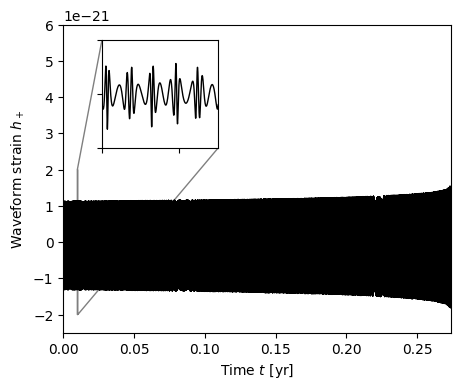

In [9]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(times/3.154e7, np.real(wave), 'k-', lw=1)
ax.set_xlabel(r"Time $t$ [yr]")
ax.set_xlim(0, t[-1]/3.154e7)
ax.set_ylabel(r"Waveform strain $h_+$")
ax.set_ylim(-2.5e-21, 6.0e-21)

# inset Axes....
x1, x2, y1, y2 = 0.01, 0.0103, -2.0e-21, 2.0e-21  # subregion of the original image
axins = ax.inset_axes(
    [0.1, 0.6, 0.3, 0.35],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(times/3.154e7, np.real(wave), 'k-', lw=1)
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

## Discrete Wavelet Transform

Perform the discrete wavelet transform numerically on the entire EMRI signal (inc. all harmonics).

In [10]:
dt = 10.0                  # sampling interval [s]
num_samples_per_dT = 3600  # wavelet length \Delta T = 10 hours

desired_length = WDM.utils.next_multiple(times.shape[0], num_samples_per_dT)

Nt = desired_length // num_samples_per_dT
Nf = desired_length // Nt

assert Nt * Nf == desired_length, "Desired length not achieved!"

wdm = WDM.WDM.WDM_transform(dt=dt, Nf=Nf, N=desired_length, q=8, calc_m0=True)

print(wdm)

wave_padded, padding_mask = WDM.utils.pad_signal(wave, desired_length)

w_plus_nm = wdm(np.real(wave_padded))
w_cross_nm = wdm(np.real(wave_padded))

WDM_transform(Nf=3600, N=864000, q=8, d=4, A_frac=0.25, calc_m0=True)
self.Nt = 240 time cells
self.Nf = 3600 frequency cells
self.dT = 36000.0 time resolution
self.dF = 1.388888888888889e-05 frequency resolution
self.K = 57600 window length


Plot the discrete wavelet transform. You can see all the harmonics in this time-frequency representation.

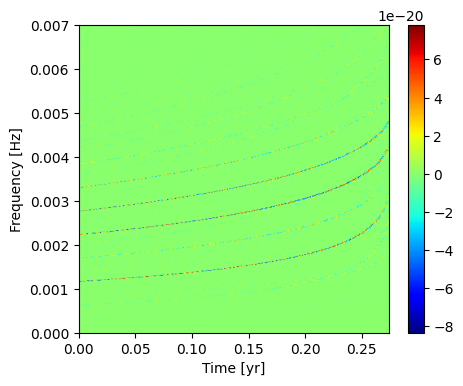

In [11]:
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(w_plus_nm.T, aspect='auto', origin='lower',
               extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
ax.set_xlabel('Time [yr]')
ax.set_xticks(np.arange(0, 0.26, 0.05)*3.154e7, labels=[f"{f:.2f}" for f in np.arange(0, 0.26, 0.05)])
ax.set_ylabel('Frequency [Hz]')
ax.set_ylim(0, 0.007)
fig.colorbar(im, ax=ax)
plt.show()

## Isolate a Specific Mode

In [26]:
ell, m, n = 2, 2, 0

specific_modes = [(ell, m, n)]

phase_sparse_data = m*Phi_phi + n*Phi_r
A = amp(0., p, e, x, specific_modes=specific_modes)[(ell, m, n)] / ((dist * Gpc) / (mu * MRSUN_SI))
Ylm = ylm_gen(np.array([ell]), np.array([m]), theta, phi)
amplitude_sparse_data = A * Ylm

phase_interp = CubicSpline(t, phase_sparse_data, extrapolate=True)
amplitude_phase_interp = CubicSpline(t, np.unwrap(np.angle(amplitude_sparse_data)), extrapolate=True)
amplitude_interp = CubicSpline(t, np.abs(amplitude_sparse_data), extrapolate=True)

Plot this single mode.

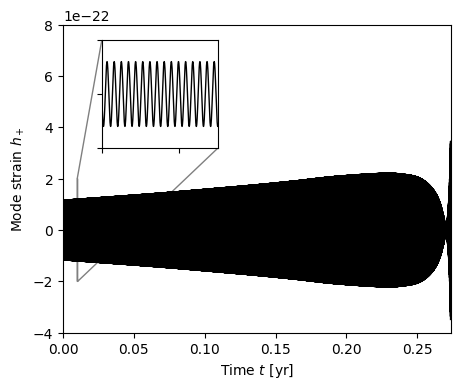

In [27]:
mode = amplitude_interp(times) * np.exp((1j)*(phase_interp(times)+amplitude_phase_interp(times)))

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(times/3.154e7, np.real(mode), 'k-', lw=1)
ax.set_xlabel(r"Time $t$ [yr]")
ax.set_xlim(0, t[-1]/3.154e7)
ax.set_ylabel(r"Mode strain $h_+$")
ax.set_ylim(-4.0e-22, 8.0e-22)

# inset Axes....
x1, x2, y1, y2 = 0.01, 0.0103, -2.0e-22, 2.0e-22  # subregion of the original image
axins = ax.inset_axes(
    [0.1, 0.6, 0.3, 0.35],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(times/3.154e7, np.real(mode), 'k-', lw=1)
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

## Fast TD -> TFD Transform

Set up the transformer object.

In [ ]:
fdot_grid_spec = (0.0, 3.0e-9, 3)

transformer = TFW.code.TD_to_TFD_transform.Transformer(wdm, num_freq_points=40, num_pixels=21, fdot_grid_spec=fdot_grid_spec)

Evaluate the harmonic amplitude, phase, frequency, and frequency derivative on the sparse grid of wavelet times.

In [28]:
t_n = jnp.arange(wdm.Nt) * wdm.dT
A_n = jnp.array(amplitude_interp(t_n))
Phi_n = jnp.array(phase_interp(t_n) + amplitude_phase_interp(t_n))
f_n = jnp.array(phase_interp.derivative()(t_n) + amplitude_phase_interp.derivative()(t_n)) / (2.0 * jnp.pi)
fdot_n = jnp.array(phase_interp.derivative(nu=2)(t_n) + amplitude_phase_interp.derivative(nu=2)(t_n)) / (2.0 * jnp.pi)

Compute the fast transform of a single mode.

In [29]:
mode = transformer.transform(A_n, Phi_n, f_n, fdot_n)
w_plus_mode_nm, w_cross_mode_nm = jnp.real(mode), jnp.imag(mode)

Plot this single mode in the time-frequency representation.

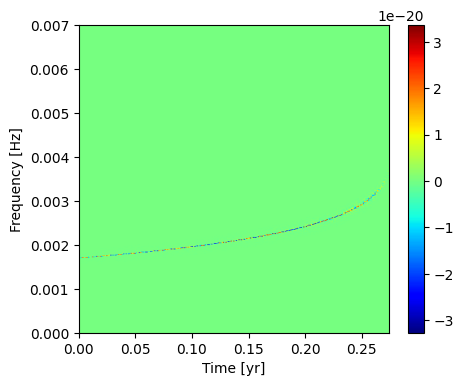

In [30]:
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(w_plus_mode_nm.T, aspect='auto', origin='lower',
               extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
ax.set_xlabel('Time [yr]')
ax.set_xticks(np.arange(0, 0.26, 0.05)*3.154e7, labels=[f"{f:.2f}" for f in np.arange(0, 0.26, 0.05)])
ax.set_ylabel('Frequency [Hz]')
ax.set_ylim(0, 0.007)
fig.colorbar(im, ax=ax)
plt.show()

## Apply the Fast Transform to the Full EMRI Signal

Apply the transform to each mode one by one.

Included modes: $(2,2,n)$ for $n\in\{-1,0,1,2,3\}$.

In [42]:
w_plus_allmodes_nm = np.zeros_like(w_plus_nm)
w_cross_allmodes_nm = np.zeros_like(w_cross_nm)

for n in np.arange(-1, 3+1):

    ell, m = 2, 2

    specific_modes = [(ell, m, n)]

    phase_sparse_data = m*Phi_phi + n*Phi_r
    A = amp(0., p, e, x, specific_modes=specific_modes)[(ell, m, n)] / ((dist * Gpc) / (mu * MRSUN_SI))
    Ylm = ylm_gen(np.array([ell]), np.array([m]), theta, phi)
    amplitude_sparse_data = A * Ylm

    phase_interp = CubicSpline(t, phase_sparse_data, extrapolate=True)
    amplitude_phase_interp = CubicSpline(t, np.unwrap(np.angle(amplitude_sparse_data)), extrapolate=True)
    amplitude_interp = CubicSpline(t, np.abs(amplitude_sparse_data), extrapolate=True)

    A_n = jnp.array(amplitude_interp(t_n))
    Phi_n = jnp.array(phase_interp(t_n) + amplitude_phase_interp(t_n))
    f_n = jnp.array(phase_interp.derivative()(t_n) + amplitude_phase_interp.derivative()(t_n)) / (2.0 * jnp.pi)
    fdot_n = jnp.array(phase_interp.derivative(nu=2)(t_n) + amplitude_phase_interp.derivative(nu=2)(t_n)) / (2.0 * jnp.pi)

    mode = transformer.transform(A_n, Phi_n, f_n, fdot_n)
    w_plus_onemode_nm, w_cross_onemode_nm = jnp.real(mode), jnp.imag(mode)

    w_plus_allmodes_nm += w_plus_onemode_nm
    w_cross_allmodes_nm += w_cross_onemode_nm

# For reasons that I don't understand, the whole signal is off by a minus sign
w_plus_allmodes_nm *= -1.0
w_cross_allmodes_nm *= -1.0

Plot the discrete wavelet transform. You can see the 5 included modes in this representation.

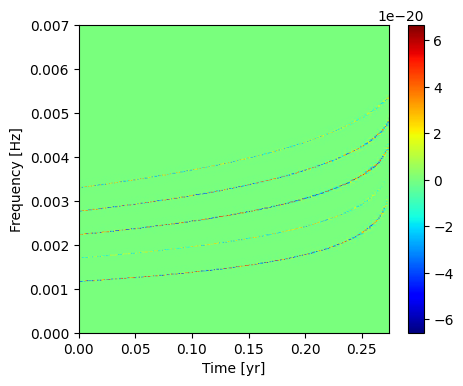

In [43]:
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(w_plus_allmodes_nm.T, aspect='auto', origin='lower',
               extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
ax.set_xlabel('Time [yr]')
ax.set_xticks(np.arange(0, 0.26, 0.05)*3.154e7, labels=[f"{f:.2f}" for f in np.arange(0, 0.26, 0.05)])
ax.set_ylabel('Frequency [Hz]')
ax.set_ylim(0, 0.007)
fig.colorbar(im, ax=ax)
plt.show()

## Mismatch

Compute the mismatch between the exact numerical transform and the fast approximation including 5 modes.

In [44]:
def wavelet_inner_product(wdm : WDM.WDM.WDM_transform,
                          Anm : jnp.ndarray, Bnm : jnp.ndarray, 
                          f_low : float=None, f_high : float=None, 
                          t_low : float=None, t_high : float=None) -> float:
    """ 
    Compute white TF noise inner product between two signals with wavelet
    coefficients Anm and Bnm. This is a sum over the time-frequency grid.
    The optional arguments allow this sum to be restricted to a sub-region
    of the time-frequency grid.

    Parameters
    ---------- 
    wdm : WDM.WDM.WDM_transform
        An instance of the WDM wavelet transform class.
    Anm : jnp.ndarray
        Wavelet coefficients of first signal, shape=(Nt, Nf).
    Bnm : jnp.ndarray
        Wavelet coefficients of second signal, shape=(Nt, Nf).
    f_low : float
        Lower frequency bound of inner product. Optional.
    f_high : float
        Upper frequency bound of inner product. Optional.
    t_low : float
        Lower time bound of inner product. Optional.
    t_high : float
        Upper time bound of inner product. Optional.

    Returns
    -------
    AB : float
        The inner product.
    """
    tn = wdm.dT * jnp.arange(wdm.Nt)
    fm = wdm.dF * jnp.arange(wdm.Nf)

    t_low = t_low if t_low is not None else 0.0
    t_high = t_high if t_high is not None else wdm.T
    f_low = f_low if f_low is not None else 0.0
    f_high = f_high if f_high is not None else wdm.f_Ny

    mask = jnp.outer( jnp.logical_and(tn > t_low, tn < t_high),
                      jnp.logical_and(fm > f_low, fm < f_high) )

    AB = jnp.sum(Anm[mask]*Bnm[mask])

    return AB


edge = 25
f_low, f_high = 0.001, 0.01

wW = wavelet_inner_product(wdm, w_plus_allmodes_nm, w_plus_nm, 
                           f_low=f_low, f_high=f_high, t_low=edge*wdm.dT, t_high=wdm.T-edge*wdm.dT)
ww = wavelet_inner_product(wdm, w_plus_allmodes_nm, w_plus_allmodes_nm, 
                           f_low=f_low, f_high=f_high, t_low=edge*wdm.dT, t_high=wdm.T-edge*wdm.dT)
WW = wavelet_inner_product(wdm, w_plus_nm, w_plus_nm, 
                           f_low=f_low, f_high=f_high, t_low=edge*wdm.dT, t_high=wdm.T-edge*wdm.dT)

MM = 1.0 - wW/jnp.sqrt(ww*WW)

print(f"Mismatch = {MM:.2e}")

Mismatch = 2.35e-01
